

# Reporte de problemas fitosanitarios en plantaciones de agave
--------------------

## Equipo 36

| Nombre | Matrícula |
| ------ | --------- |
| André Martins Cordebello | A00572928 |
| Enrique Eduardo Solís Da Costa | A00572678 |
| Delbert Francisco Custodio Vargas | A01795613 |

## Avance 4: Modelos alternativos 

Este avance implica construir múltiples modelos (individuales, no ensambles) relevantes para resolver el problema y evaluar su desempeño. Diferentes algoritmos pueden comportarse de manera óptima en diferentes tipos de datos o tareas. La construcción de modelos alternativos permite explorar y evaluar cuál de ellos proporciona el mejor rendimiento para un problema particular.

Además, los modelos se pueden ajustar para determinar si se puede mejorar su rendimiento. Diferentes configuraciones de hiperparámetros pueden afectar significativamente el rendimiento de un modelo. Construir modelos alternativos implica explorar y ajustar estos hiperparámetros para encontrar la configuración óptima.

# Introducción

Durante la entrega del Avance 3, trabajamos con 2 modelos de regresión los cuáles fueron `RandomForestRegressor` y `XGBoost`. De éstos 2 modelos, el que mejor rendimiento tuvo fue el `RandomForestRegressor`, con un R^2 de `0.53`.

Por lo anterior, estaremos explorando al menos 6 modelos distintos y cambiando nuestro Feature Engineering para lograr un mejor resultado en la predicción de nuestro R^2 o `accuracy` score si decidimos trabajar sobre la variable `severity_encode`. Agregado a esto, haremos una etapa de feature engineering la cual incluirá:

- La precipitación registrada por la estación climatológica más cercana a la ubicación de la trampa muestreada durante el mismo mes en que se tomó la muestra.
- La temperatura media, maxima y mínima de la estación climatológica más cercana a la ubicación de la trampa muestreada en el mismo año y mes.

Esta información está disponible desde `https://smn.conagua.gob.mx/es/climatologia/temperaturas-y-lluvias/resumenes-mensuales-de-temperaturas-y-lluvias`, y es posible descargar esta información por medio de los scripts `smn_precipitation_downloader.py` y `smn_temp_downloader.py`, y generar los archivos CSV por medio de los scripts `smn_precipitation_builder.py` y `smn_temp_builder.py`.

# Objetivo

Con lo anterior, es importante tomar en cuenta que nuestro objetivo para esta entrega se basa en predecir el nivel de infestación con la que se catalogan los focos de infestación (seguro, leve, moderado y severo). 

Ahora, como sabemos, contamos con un dataset desbalanceado:

- El 62% de las muestras históricas son leves.
- El 35% de los registros indican un nivel seguro de severidad.
- El 1.1% se considera como moderado.
- El 0.15% de la muestra es severa.

Por lo anterior, usar una métrica como `accuracy` no es buena idea, ya que nuestros modelos podrían llegar a tener esta métrica elevado haciendo uso de una clasificación leve o segura. Por lo tanto, las métricas que debemos tomar en cuenta son las siguientes:

- `Recall`: requerimos detectar correctamente los casos positivos de la clase objetivo.
- `F1`: esta métrica nos da una idea de qué tan balanceado es nuestro modelo para todas las clases en general.
- `Precision`: nos ayudará a controlar los falsos positivos una vez logremos que nuestro `Recall` mejore.
- `AUC`: para analizar los resultados gráficamente y seleccionar el mejor modelo.

# Librerías

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from imblearn.ensemble  import BalancedRandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import BallTree
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import numpy as np
import optuna

d:\Python_Envs\torch311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carga del dataset

En esta sección cargaremos el dataset `Baseline.xlsx`, el cual contiene los `text_features` para hacer el fine-tuning de nuestro LLM.

Por lo tanto, no haremos uso de los `text_features` debido a que éstos son la combinación de varios features previos.

In [2]:
df = pd.read_excel('baseline.xlsx')
df.dtypes

Unnamed: 0                              int64
tramp_id                               object
sampling_date                  datetime64[ns]
lat                                   float64
lon                                   float64
municipality                           object
square_area                           float64
plantation_age                          int64
capture_count                         float64
state                                  object
square_area_imputed                   float64
month                                   int64
year                                    int64
year_month                             object
day_of_year_sin                       float64
day_of_year_cos                       float64
day_of_week_sin                       float64
day_of_week_cos                       float64
week_of_year_sin                      float64
week_of_year_cos                      float64
month_sin                             float64
month_cos                         

In [3]:
# Eliminamos las columnas irrelevantes para nuestros modelos.
df.drop(labels=['Unnamed: 0', 'square_area', 'text_feature_location',  'text_feature_risk', 'text_feature_capture', 'text_feature_plantation', 'text_feature_all_things'], axis=1, inplace=True)
df.dtypes

tramp_id                               object
sampling_date                  datetime64[ns]
lat                                   float64
lon                                   float64
municipality                           object
plantation_age                          int64
capture_count                         float64
state                                  object
square_area_imputed                   float64
month                                   int64
year                                    int64
year_month                             object
day_of_year_sin                       float64
day_of_year_cos                       float64
day_of_week_sin                       float64
day_of_week_cos                       float64
week_of_year_sin                      float64
week_of_year_cos                      float64
month_sin                             float64
month_cos                             float64
critical_season                         int64
severity_encoded                  

# Ahora tomaremos en cuenta el clima

## Carga de precipitación y temperatura histórica

Con base en los resultados obtenidos en nuestro Baseline, vemos con buenos ojos pensar de nuevo los features que debemos tomar en cuenta para predecir la severidad de un posible foco de infección.

Para esto, hemos descargado y procesado la información disponible de parte del Gobierno de México para tomar en cuenta:

- La precipitación en mm.
- La temperatura media, máxima y mínima 

Y haremos uso de la información proporcionada por la estación más cercana a cada muestra de nuestro dataset.

In [4]:
precipitation_df = pd.read_csv('precipitation_per_area_historical.csv')
avg_temp_df      = pd.read_csv('TMed_per_area_historical.csv')
max_temp_df      = pd.read_csv('TMax_per_area_historical.csv')
min_temp_df      = pd.read_csv('TMin_per_area_historical.csv')

print(f'El dataset de precipitacion tiene estas columnas: {precipitation_df.columns.tolist()}')
print(f'El dataset de avg_temp tiene estas columnas: {avg_temp_df.columns}')
print(f'El dataset de max_temp tiene estas columnas: {max_temp_df.columns}')
print(f'El dataset de min_temp tiene estas columnas: {min_temp_df.columns}')

El dataset de precipitacion tiene estas columnas: ['lon', 'lat', 'state', 'cve_sih', 'name', 'precipitation(mm)', 'year-month']
El dataset de avg_temp tiene estas columnas: Index(['lon', 'lat', 'state', 'cve_sih', 'name', 'TMed', 'year-month'], dtype='object')
El dataset de max_temp tiene estas columnas: Index(['lon', 'lat', 'state', 'cve_sih', 'name', 'TMax', 'year-month'], dtype='object')
El dataset de min_temp tiene estas columnas: Index(['lon', 'lat', 'state', 'cve_sih', 'name', 'TMin', 'year-month'], dtype='object')


In [5]:
precipitation_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,158067.0,1.717909e+08,9.853862e+08,873.0,10172.0,97021111.0,1.006344e+08,9.999958e+09
lat,158067.0,5.697327e+07,3.079344e+08,147.0,2345.0,18794167.0,2.107444e+07,3.270472e+09
precipitation(mm),158020.0,8.051705e+01,1.165051e+02,0.0,3.0,33.2,1.153200e+02,1.894000e+03


In [6]:
avg_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163149.0,-101.184182,5.850756,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163149.0,22.092611,4.143454,-99.90,19.12,20.8,25.03,32.70
TMed,163149.0,22.292233,5.657826,-99.90,18.10,22.3,27.00,41.80


In [7]:
max_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163237.0,-101.183637,5.850671,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163237.0,22.092476,4.143737,-99.90,19.12,20.8,25.03,32.70
TMax,163237.0,29.519894,5.428911,-99.90,25.60,29.7,33.60,51.10


In [8]:
min_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163264.0,-101.182702,5.850383,-118.29,-104.37,-100.30,-98.15,-86.74
lat,163264.0,22.091303,4.143190,-99.90,19.12,20.75,25.03,32.70
TMin,163264.0,15.092148,6.768767,-99.90,10.10,15.00,20.80,38.00


Como notamos que la información de temperatura contiene registros con valores negativos de -99.90 grados de temperatura, y como sabemos que esto no pudo pasar en alguno de los estados muestreados, procedemos a eliminar estos registros que seguramente son resultado de una mala muestra.

In [9]:
precipitation_df = precipitation_df[ precipitation_df['precipitation(mm)'] >= 0 ]
max_temp_df      = max_temp_df[ max_temp_df['TMax'] >= -99 ]
avg_temp_df      = avg_temp_df[ avg_temp_df['TMed'] >= -99 ]
min_temp_df      = min_temp_df[ min_temp_df['TMin'] >= -99 ]

In [10]:
precipitation_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,158020.0,1.718176e+08,9.855313e+08,873.0,10172.0,97021111.0,1.006344e+08,9.999958e+09
lat,158020.0,5.698401e+07,3.079796e+08,147.0,2345.0,18789167.0,2.107444e+07,3.270472e+09
precipitation(mm),158020.0,8.051705e+01,1.165051e+02,0.0,3.0,33.2,1.153200e+02,1.894000e+03


In [11]:
avg_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163144.0,-101.184222,5.850841,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163144.0,22.096349,4.088107,14.63,19.12,20.8,25.03,32.70
TMed,163144.0,22.295978,5.617327,-0.80,18.10,22.3,27.00,41.80


In [12]:
max_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163232.0,-101.183677,5.850757,-118.29,-104.37,-100.3,-98.16,-86.74
lat,163232.0,22.096213,4.088424,14.63,19.12,20.8,25.03,32.70
TMax,163232.0,29.523859,5.381533,3.20,25.60,29.7,33.60,51.10


In [13]:
min_temp_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lon,163259.0,-101.182741,5.850468,-118.29,-104.37,-100.30,-98.15,-86.74
lat,163259.0,22.095040,4.087879,14.63,19.12,20.75,25.03,32.70
TMin,163259.0,15.095670,6.738888,-13.30,10.10,15.00,20.80,38.00


Con lo anterior, confirmamos que nuestros datasets de precipitación y temperaturas son correctos.

#### Información sobre el clima

In [14]:
# Year-Month es una columna planeada para hacer el match con las estaciones más cercanas a cada trampa registrada
df = df.rename(columns={'year_month': 'year-month'})

In [15]:
# Esta función nos ayudará a:
# - Filtrar por año-mes las estaciones disponibles.
# - Identificar la estación más cercana al usar la formular de Haversine (esta toma en cuenta la curvatura de la Tierra)
# - Nuevamente usamos BallTree para hacer uso de funciones vectorizadas y no calcular la distancia por medio de ciclos


def find_weather_station(df_samples, weather_df, value_col):
    
    results = []
    
    for ym, group in df_samples.groupby('year-month'):
        
        subset = weather_df[(weather_df['year-month'] == ym) & (weather_df[value_col].notna())]
        
        if subset.empty:
            results.extend([np.nan] * len(group))
            continue
        
        # Usamos BallTree para calcular la distancia, ya que este modelo está vectorizado
        tree = BallTree(np.radians(subset[['lat', 'lon']].values), metric='haversine')
        
        # Obtenemos la distancia y elemento mas cercano
        distances, indices = tree.query(np.radians(group[['lat', 'lon']].values), k=1)
        nearest_values = subset.iloc[indices.flatten()][value_col].values
        results.extend(nearest_values)

    return np.array(results)

In [16]:
# Aquí podemos definir de cuando a cuando filtrar nuestro DataSet para hacer experimentos rapidos
# con cada tipo de modelo.

df_filtered = df[(df['sampling_date'].dt.year >= 2014) & 
                 (df['sampling_date'].dt.year <= 2025)]

print(f"Original: {len(df)} | Filtrado: {len(df_filtered)}")

Original: 827856 | Filtrado: 827856


In [ ]:
# Agregamos las columnas de temperatura y precipitacion a nuestro dataset. La idea principal es que 
# conocemos esto porque la SMN mantiene en su sitio web los valores históricos de precipitacion,
# temperatura maxima, minima y promedio por estacion meteorologica, y como conocemos
# la ubicacion de las estaciones y trampas, podemos ver cual es la estacion mas cercana y adjuntar esa
# data a nuestro dataset.

df_filtered['precipitation'] = find_weather_station(df_filtered, precipitation_df, 'precipitation(mm)')
df_filtered['avg_temp'] = find_weather_station(df_filtered, avg_temp_df, 'TMed')
df_filtered['max_temp'] = find_weather_station(df_filtered, max_temp_df, 'TMax')
df_filtered['min_temp'] = find_weather_station(df_filtered, min_temp_df, 'TMin')


# Debemos descomenttar la siguiente línea de código si queremos generar un archivo de Excel que incluya la informacion del clima.
# df_filtered.to_excel('data_with_weather_information.xlsx', index= False )

In [3]:
# Esta línea de código permite cargar la información lista con los aspectos de precipitacion y temperatura
df_filtered = pd.read_excel('data_with_weather_information.xlsx')

In [4]:
# Confirmamos que tenemos un dataset desbalanceado

print("Porcentajes de presencia de severity_encoded:")
df_filtered['severity_encoded'].value_counts() / len(df_filtered) * 100

Porcentajes de presencia de severity_encoded:


severity_encoded
1    62.650872
0    35.207210
2     1.990201
3     0.151717
Name: count, dtype: float64

In [5]:
print(f"Cantidad de casos con severidad alta del 2014 al 2024: {len(df_filtered[(df_filtered['severity_encoded'] == 3) &(df_filtered['sampling_date'].dt.year < 2025)])}")
print(f"Cantidad de casos con severidad alta en el 2025: {len(df_filtered[(df_filtered['severity_encoded'] == 3) &(df_filtered['sampling_date'].dt.year >= 2025)])}")

Cantidad de casos con severidad alta del 2014 al 2024: 1146
Cantidad de casos con severidad alta en el 2025: 110


# RandomForest

Durante la entrega del Avance 3, trabajamos con 2 modelos de regresión los cuales fueron `RandomForestRegressor` y `XGBoost`. Con esto, `RandomForestRegressor` tuvo mejores resultados, por lo que el primer modelo a implementar con la nueva información del clima será este mismo.

En  este caso, como contamos con un dataset desbalanceado, haremos uso de la propiedad de `balanced_subsample` de `RandomForestClassifier`. Para esta implementación, generamos nuestros datasets de la siguiente manera:

- `Train set`: los datos de 2014 a 2024.
- `Test set`: los datos de 2025


La idea de esto es predecir los casos de todo el año 2025, de manera que podamos comparar los resultados de cada modelo.

Algo importante es que nuestro Sponsor, la CNIT, considera que solo debemos dar  importancia a la predicción de focos con una severidad o riesgo alto de infestación. Por lo tanto, nuestra clase objetivo de `severity_encoded` es la clase **`3`**.

In [ ]:
# Copiamos el dataframe con la información
rf_df = df_filtered.copy()

# Hacemos un encoding basico para State y Municipalidad
for col in ['state', 'municipality']:
    le = LabelEncoder()
    rf_df[col] = le.fit_transform(rf_df[col])

# Generamos la mascara para obtener los datos de antes del 2025 y del 2025 por separada
train_mask = rf_df['sampling_date'].dt.year < 2025
test_mask  = rf_df['sampling_date'].dt.year == 2025

# Excluimos la variable objetivo (severity_encoded) y algunos unas variables o features que ya tenemos contenidos en nuestros
# features creados. `capture_count` no podemos tomarlo en cuenta porque se relaciona directamente con la severidad.
exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date'
]

# Cargamos los features a tomar en cuenta (obviamos los features en exclude_cols)
features = [col for col in rf_df.columns if col not in exclude_cols]

# Generamos nuestro split de entrenamiento y test por medio de las mascaras train_mask y test_mask
X_train, y_train = rf_df.loc[train_mask, features], rf_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = rf_df.loc[test_mask,  features], rf_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

# Definimos algunos hiperparámetros para RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

# Hacemos fit del modelo
rf_model.fit(X_train, y_train)

# Predecimos sobre el dataset de prueba o test
y_pred = rf_model.predict(X_test)

# Mostramos los resultados
print("Resultados para RandomForest:\n")
print(classification_report(y_test, y_pred))

y_pred_proba_rf  = rf_model.predict_proba(X_test)

Resultados para RandomForest:

              precision    recall  f1-score   support

           0       0.30      0.11      0.16     24445
           1       0.76      0.93      0.84     82928
           2       0.36      0.01      0.02      2544
           3       0.40      0.86      0.55       110

    accuracy                           0.72    110027
   macro avg       0.46      0.48      0.39    110027
weighted avg       0.65      0.72      0.67    110027



`RandomForestClassifier` se tardó 1 minuto y 15 segundos en generar un modelo útil. Algo importante de notar con este modelo es lo siguiente:

- La clase a predecir (`3`) tiene un `recall` bastante bueno a pesar de que la cantidad de muestras en el train y test set con esta clasificación es bastante baja. Esto quiere decir que nuestro modelo sabe reconocer casos verdaderos positivos de forma casi perfecta.
- Al inspeccionar la métrica `precision`, notamos que para la clase objetivo esta es pobre. Esto quiere decir que solo el 35% de los casos predecidos para el label `3` es correcto.
- Nuestro `f1 score` indica que, a pesar de nuestro recall alto, tenemos un balance entre leve a moderado entre nuestras métricas `precision` y `recall`.
- Es importante notar que nuestro modelo falla completamente en identificar la clase `2`, mientras que un éxito moderado al identificar la clase `1` y un éxito bastante pobre al predecir la clase `0`.
- En nuestro caso, el `accuracy` no es una métrica confiable ya que aunque nuestro modelo prediga el 100% de las veces que se tiene un escenario de clase `1` (algo que es imposible), estaría correcto el 62% de las veces ya que existe un desbalance en nuestro dataset.

En general, este modelo podría generar muchas falsas alertas sobre posibles focos de infestación, lo que tendría su ventaja en ser un modelo bastante preventivo pero a su vez podría generar más costos de operación al predecir falsamente brotes de infestación severos.

# Con `XGBoost`

Para XGBoost haremos uso de los mismos train y test dataset que los que definimos para `RandomForestClassifier`. Usaremos también la versión compatible con nuestra GPU para que el modelo se entrene más rápido.

Debemos mencionar que para este modelo, hicimos uso de la variable `class_weights` para darle más peso o relevancia a las clases minoritarias.

In [23]:
# Copiamos el dataframe con la información
xg_df = df_filtered.copy()

# Hacemos un encoding basico para State y Municipalidad
for col in ['state', 'municipality']:
    le = LabelEncoder()
    xg_df[col] = le.fit_transform(xg_df[col])

# Generamos la mascara para obtener los datos de antes del 2025 y del 2025 por separada
train_mask = xg_df['sampling_date'].dt.year < 2025
test_mask  = xg_df['sampling_date'].dt.year == 2025

# Excluimos la variable objetivo (severity_encoded) y algunos unas variables o features que ya tenemos contenidos en nuestros
# features creados. `capture_count` no podemos tomarlo en cuenta porque se relaciona directamente con la severidad.
exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date'
]

# Cargamos los features a tomar en cuenta (obviamos los features en exclude_cols)
features = [col for col in xg_df.columns if col not in exclude_cols]

# Generamos nuestro split de entrenamiento y test por medio de las mascaras train_mask y test_mask
X_train, y_train = xg_df.loc[train_mask, features], xg_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = xg_df.loc[test_mask,  features], xg_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025


class_counts = y_train.value_counts().sort_index()
num_classes = len(class_counts)
total = len(y_train)
class_weights = {i: total / (num_classes * count) for i, count in class_counts.items()}

weights = y_train.map(class_weights)

xgb_model = XGBClassifier(
    tree_method='hist',
    device='cuda',
    objective='multi:softprob',
    eval_metric='mlogloss',
    n_estimators=300,
    max_depth=10,
    learning_rate=0.0001,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train, sample_weight=weights)

y_pred = xgb_model.predict(X_test)

print("Resultados para XGBoost (version GPU):")
print(classification_report(y_test, y_pred))

y_pred_proba_xgb = xgb_model.predict_proba(X_test)

Resultados para XGBoost (version GPU):
              precision    recall  f1-score   support

           0       0.26      0.22      0.24     24445
           1       0.76      0.77      0.77     82928
           2       0.13      0.26      0.17      2544
           3       0.32      0.91      0.48       110

    accuracy                           0.64    110027
   macro avg       0.37      0.54      0.41    110027
weighted avg       0.64      0.64      0.64    110027



Al usar la versión de GPU de XGBoost, el modelo tomó 30 segundos de entrenamiento. Esto es una mejora de más del doble de velocidad respecto a `RandomForestClassifier`. Con esto, notamos los siguientes resultados:

- La `precision` de este modelo es un poco peor respecto que lo obtenido por `RandomForestClassifier` para la `clase 3`. Esto indica que de las predicciones hechas como clase `3`, solo el 32% de las mismas fue correcta.
- El `recall` sigue siendo bastante alto, lo que quiere decir que el modelo capturó correctamente los verdaderos positivos de la clase `3`.
- Notamos que la `accuracy` es peor que la de `RandomForestClassifier`, pero a su vez vemos que este modelo hizo un mejor trabajo en reconocer la clase `2`, aunque tiene un peor desempeño para reconocer las clases `0` y `1`.

Al igual que `RandomForestClassifier`, notamos que `XGBoost` es un modelo que podría generar muchas falsas alertas sobre brotes de infestación altos. A pesar de esto, es un modelo más flexible en cuanto a la predicción de todas las clases en general y no solo de las clases `3` y `1`.

# `DecisionTree`

In [25]:
dt_df = df_filtered.copy()

for col in ['state', 'municipality']:
    le = LabelEncoder()
    dt_df[col] = le.fit_transform(dt_df[col])

train_mask = dt_df['sampling_date'].dt.year < 2025
test_mask  = dt_df['sampling_date'].dt.year == 2025

exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date'
]

features = [col for col in dt_df.columns if col not in exclude_cols]

X_train, y_train = dt_df.loc[train_mask, features], dt_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = dt_df.loc[test_mask,  features], dt_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

dt = DecisionTreeClassifier(
    criterion= 'entropy',        
    max_depth=10,          
    min_samples_split=4,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    max_features= 'log2'
)

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print("Resultados DecisionTree:")
print(classification_report(y_test, y_pred, digits=3))

y_pred_proba_dt  = dt.predict_proba(X_test)

Resultados DecisionTree:
              precision    recall  f1-score   support

           0      0.234     0.203     0.217     24445
           1      0.756     0.778     0.767     82928
           2      0.056     0.060     0.058      2544
           3      0.079     0.536     0.138       110

    accuracy                          0.634    110027
   macro avg      0.281     0.394     0.295    110027
weighted avg      0.623     0.634     0.628    110027



`DecisionTree` es el modelo más rápido de entrenar, ya que tomó solamente 2 segundos y obtuvimos resultados similares a `XGBoost` y `RandomForestClassifier`. Con esto, el resumen de resultados es el siguiente:

- Nuevamente notamos que las clases `0` y `2` tienen mejores resultados que con `RandomForestClassifier` y valores parecidos a `XGBoost`. Esto sugiere que este modelo, que tardó menos en entrenarse, podría ser el candidato a optimizar.
- Afuera de esto, la clase objetivo (`3`) muestra que capturamos el 36% de casos por medio de la `precision`, entre los cuales se incluyen el 98% de casos reales. Esto quiere decir que el modelo también será un generador de alertas falsas, que operativamente podría generar más costos pero a largo plazo podría ser mejor para evitar brotes de infestaciones severas del gorgojo.
- El `accuracy` fue más bajo que `RandomForestClassifier` y mayor que `XGBoost`, pero este siempre puede ser engañoso ya que tenemos un dataset desbalanceado.
- Para la clase `2`, vemos que es el modelo que peor la predice hasta este punto en el notebook.

# Perceptrón (MLP)

Para el modelo de MLP, cambiaremos un poco la estrategia:

- Codificaremos los estados con OneHot encoding, ya que ésto no afecta el rendimiento del modelo.
- Configuraremos distintos pesos para las distintas clases objetivo (0, 1, 2 y 3), de forma que la red neuronal entienda que confundirse en predecir las clases minoritarias es peor que confundirse en las clases mayoritarias.
- Configuraremos el modelo para detenerse al no mejorar las predicciones por 20 pasos forward y backward seguidos.
- Escalaremos los valores numéricos para evitar overfitting o darle demasiada importancia solo a ciertos features 
  - `distance_to_nearest_hotspot` podría tomar demasiada relevancia, al tener un valor maximo de 999 al no encontrar hotspots cercanos en los últimos 15 días.

In [26]:
split_date = pd.Timestamp('2025-01-01')

train_df = df_filtered[df_filtered['sampling_date'] < split_date].copy()
test_df  = df_filtered[df_filtered['sampling_date'] >= split_date].copy()


X = df_filtered.drop(columns=['severity_encoded','tramp_id', 'capture_count', 'month', 'year-month', 'sampling_date'])
y = df_filtered['severity_encoded']


le = LabelEncoder()
X['municipality_encoded'] = le.fit_transform(X['municipality'].astype(str))

ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
state_encoded = ohe.fit_transform(X[['state']])

state_encoded_df = pd.DataFrame(
    state_encoded,
    columns=ohe.get_feature_names_out(['state']),
    index=X.index
)

X = X.drop(['state', 'municipality'], axis=1)

X_encoded = pd.concat([X, state_encoded_df], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_encoded, y, test_size=0.2, stratify=y, random_state=42
)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Cambiamos la resolucion de nuestros numeros para acelerar el entrenamiento del modelo MLP
X_train_scaled = X_train_scaled.astype('float32')
X_valid_scaled = X_valid_scaled.astype('float32')

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 16),
    activation='relu',
    solver='adam',
    learning_rate_init=0.0001,
    alpha=0.001,
    batch_size=256,
    max_iter=50,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42,
    warm_start=True,
    validation_fraction=0.05
)

# Armamos un ciclo para asegurar que nuestro modelo MLP pueda
# ver la mayoria de casos del test de entrenamiento.
for i in range(6):
    print(f"Entrenando el chunk {i+1}")
    mlp.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_pred = mlp.predict(X_valid_scaled)

y_pred_proba_mlp = mlp.predict_proba(X_valid_scaled)

print("Resultados para MLP:\n")
print(classification_report(y_valid, y_pred))

Entrenando el chunk 1


d:\Python_Envs\torch311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Entrenando el chunk 2
Entrenando el chunk 3
Entrenando el chunk 4
Entrenando el chunk 5
Entrenando el chunk 6
Resultados para MLP:

              precision    recall  f1-score   support

           0       0.61      0.65      0.63     58293
           1       0.77      0.49      0.60    103733
           2       0.05      0.43      0.09      3295
           3       0.03      0.79      0.05       251

    accuracy                           0.55    165572
   macro avg       0.36      0.59      0.34    165572
weighted avg       0.70      0.55      0.60    165572



`MLP` tomó 25 minutos de entrenamiento, lo que hace el modelo más lento hasta ahora. Con esto, notamos que también tiene problemas para identificar la clase `2`, y al usar otro tipo de arquitectura sugiere que esta clase podría ser mucho más complicada de detectar que las otras 3 clases. Esto nos podría dar una idea de que la clase 2 puede ser un estado transitorio o bien, las características y patrones para esta clase son demasiado complejos.

Ahora bien, el resumen de métricas es el siguiente:

- Este modelo es el peor hasta el momento para identificar la clase `2`.
- Este modelo es el peor para detectar la clase `3`.
- `f1 score` sugiere que este modelo no tiene un balance entre predecir correctamente las clasificaciones y encontrar los verdaderos positivos dentro de nuestro dataset de test.
- En sí, este modelo no será útil para alertar o predecir hacia dónde se debe dirigir el centro de operaciones de la CNIT para encontrar posibles brotes de infestación.

# LightGBM

`LightGBM` es un framework el cual utiliza algoritmos basados en árboles. De entrada, por los resultados anteriores, sabemos que probablemente tengamos un modelo que encontrará los verdaderos positivos de la clase objetivo, pero que probablemente se confunda menos al predecir la clase objetivo.

Este algoritmo tiene la ventaja de poder  hacer uso de la GPU.

Por último, utilizaremos un setup como en `RandomForestClassifier`, `XGBoost` y `DecisionTree`.

In [27]:
lgbm_df = df_filtered.copy()

for col in ['state', 'municipality']:
    le = LabelEncoder()
    lgbm_df[col] = le.fit_transform(lgbm_df[col])
    
    
categorical_features = ['municipality', 'state', 'critical_season' ]

train_mask = lgbm_df['sampling_date'].dt.year < 2025
test_mask  = lgbm_df['sampling_date'].dt.year == 2025

exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date'
]

features = [col for col in lgbm_df.columns if col not in exclude_cols]

X_train, y_train = lgbm_df.loc[train_mask, features], lgbm_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = lgbm_df.loc[test_mask,  features], lgbm_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

lgbm = LGBMClassifier(
    boosting_type='gbdt', 
    objective='multiclass', 
    num_class=4,            
    class_weight='balanced',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=-1,
    num_leaves=31,
    random_state=42,
    device='gpu',
    is_unbalance=True
)

lgbm.fit(X_train, y_train)


y_pred = lgbm.predict(X_test, categorical_features=categorical_features)

print("Resultados para LightGBM:\n\n")
print(classification_report(y_test, y_pred, digits=3))

y_pred_proba_lgbm = lgbm.predict_proba(X_test)

Resultados para LightGBM:


              precision    recall  f1-score   support

           0      0.244     0.252     0.248     24445
           1      0.759     0.702     0.729     82928
           2      0.094     0.290     0.142      2544
           3      0.396     0.991     0.566       110

    accuracy                          0.593    110027
   macro avg      0.373     0.559     0.421    110027
weighted avg      0.629     0.593     0.609    110027



Con `LighGBM` esperamos alrededor de 18 segundos de entrenamiento al hacer uso de la GPU. También notamos que:

- Cuando se predice la clase `3`, el modelo es correcto en el 40% de las veces.
- De los casos predecidos como `3`, se incluye al 99% de verdaderos positivos.
- Vemos un mejor desempeño en predecir la clase `2` respecto a `MLP`, pero un peor desempeño respecto a predecir esta misma clase respecto a `RandomForestClassifier`, `XGBoost` y `DecisionTree`.
- El `F1 Score` obtenido es el mejor hasta el momento, lo que significa que tenemos el mejor balance entre `precision` y `recall` hasta el momento.

# BalancedRandomForestClassifier

Este clasificador se diferencia de `RandomForestClassifier` en lo siguiente:

- Cada arbol que se entrenará se construye a partir de un train dataset que balancea las clases minoritarias. Esto significa que se crean muestras sintéticas de las clases reconocidas como minoritarias en nuestro dataset.

Por lo anterior, para comparar el modelo, haremos  uso  del mismo preo-procesamiento que `RandomForestClassifier` y compararemos los resultados.

In [28]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Copiamos el dataframe con la información
bl_rf_df = df_filtered.copy()

# Hacemos un encoding basico para State y Municipalidad
for col in ['state', 'municipality']:
    le = LabelEncoder()
    bl_rf_df[col] = le.fit_transform(bl_rf_df[col])

# Generamos la mascara para obtener los datos de antes del 2025 y del 2025 por separada
train_mask = bl_rf_df['sampling_date'].dt.year < 2025
test_mask  = bl_rf_df['sampling_date'].dt.year == 2025

# Excluimos la variable objetivo (severity_encoded) y algunos unas variables o features que ya tenemos contenidos en nuestros
# features creados. `capture_count` no podemos tomarlo en cuenta porque se relaciona directamente con la severidad.
exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year', 'year-month', 'sampling_date'
]

# Cargamos los features a tomar en cuenta (obviamos los features en exclude_cols)
features = [col for col in bl_rf_df.columns if col not in exclude_cols]

# Generamos nuestro split de entrenamiento y test por medio de las mascaras train_mask y test_mask
X_train, y_train = bl_rf_df.loc[train_mask, features], bl_rf_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = bl_rf_df.loc[test_mask,  features], bl_rf_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025


brf_model = BalancedRandomForestClassifier(
    criterion = 'entropy',
    max_features='log2',
    n_estimators=100,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=4,
    sampling_strategy= 'not majority',
    random_state=42,
    n_jobs=-1
)

brf_model.fit(X_train, y_train)

y_pred = brf_model.predict(X_test)
print("Resultados para Balanced Random Forest:\n\n")
print(classification_report(y_test, y_pred, digits=3))

Resultados para Balanced Random Forest:


              precision    recall  f1-score   support

           0      0.000     0.000     0.000     24445
           1      0.754     0.999     0.860     82928
           2      0.000     0.000     0.000      2544
           3      0.408     0.445     0.426       110

    accuracy                          0.754    110027
   macro avg      0.291     0.361     0.321    110027
weighted avg      0.569     0.754     0.648    110027



d:\Python_Envs\torch311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Python_Envs\torch311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Python_Envs\torch311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Con los resultados anteriores, notamos que `BalancedRandomForestClassifier` tiene la mejor `precision`, pero el peor `recall` y el peor rendimiento hasta el momento. Esto lo sabemos de inmediato porque el modelo solo hace 2 cosas:

- Clasifica los registros como `1` o `3`, pero ninguno como perteneciente a la clase `0` o `2`.

Por lo tanto, este modelo  no vale la pena seguirlo probando ya que notamos que, aunque tiene el mejor accuracy hasta el momento, esto lo logra clasificando casi todo con un label de `1`. En esencia este modelo convirtió nuestro dataset en un problema binario.

# Catboost

In [29]:
from catboost import CatBoostClassifier, Pool

# Copiamos el dataframe con la información
cb_df = df_filtered.copy()

# Hacemos un encoding basico para State y Municipalidad
for col in ['state', 'municipality']:
    le = LabelEncoder()
    cb_df[col] = le.fit_transform(cb_df[col])

# Generamos la mascara para obtener los datos de antes del 2025 y del 2025 por separada
train_mask = cb_df['sampling_date'].dt.year < 2025
test_mask  = cb_df['sampling_date'].dt.year == 2025

# Excluimos la variable objetivo (severity_encoded) y algunos unas variables o features que ya tenemos contenidos en nuestros
# features creados. `capture_count` no podemos tomarlo en cuenta porque se relaciona directamente con la severidad.
exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year', 'year-month', 'sampling_date',
]

# Cargamos los features a tomar en cuenta (obviamos los features en exclude_cols)
features = [col for col in cb_df.columns if col not in exclude_cols]

# Generamos nuestro split de entrenamiento y test por medio de las mascaras train_mask y test_mask
X_train, y_train = cb_df.loc[train_mask, features], cb_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = cb_df.loc[test_mask,  features], cb_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025


cat_model = CatBoostClassifier(
    iterations=1000,                
    learning_rate=0.005,            
    depth=12,                      
    loss_function='MultiClass',    
    eval_metric='TotalF1',         
    auto_class_weights='Balanced', 
    random_seed=42,
    task_type='GPU',               
    verbose=200
)

categorical_cols = ['state', 'municipality']

cat_model.fit(
    X_train,
    y_train,
    cat_features=categorical_cols if 'categorical_cols' in locals() else None,
    eval_set=(X_test, y_test),
    use_best_model=True,
    sample_weight=weights
)

y_pred = cat_model.predict(X_test)
y_pred = y_pred.flatten()

print("\n\nResultados para CatBoost:\n")
print(classification_report(y_test, y_pred))

y_proba_cb = cat_model.predict_proba(X_test)

0:	learn: 0.6775412	test: 0.5753067	best: 0.5753067 (0)	total: 198ms	remaining: 3m 18s
200:	learn: 0.7040554	test: 0.6068382	best: 0.6074571 (192)	total: 37.5s	remaining: 2m 29s
400:	learn: 0.7157057	test: 0.6140806	best: 0.6147831 (349)	total: 1m 13s	remaining: 1m 50s
600:	learn: 0.7286127	test: 0.6174413	best: 0.6174413 (600)	total: 1m 51s	remaining: 1m 14s
800:	learn: 0.7395352	test: 0.6218048	best: 0.6218458 (793)	total: 2m 29s	remaining: 37.2s
999:	learn: 0.7503166	test: 0.6228211	best: 0.6235251 (874)	total: 3m 9s	remaining: 0us
bestTest = 0.6235250866
bestIteration = 874
Shrink model to first 875 iterations.


Resultados para CatBoost:

              precision    recall  f1-score   support

           0       0.30      0.36      0.33     24445
           1       0.78      0.68      0.73     82928
           2       0.07      0.25      0.11      2544
           3       0.24      0.97      0.39       110

    accuracy                           0.60    110027
   macro avg       0.3

# Algunos modelos junto a SMOTENC

Debido a que tenemos un problema de clases desbalanceadas, haremos un test rápido con SMOTENC para confirmar si la aplicación de esta técnica podría ayudarnos en mejorar nuestros modelos.

Esto nos ayuda a tener una idea general y prototipado accesible antes de correr SMOTENC en nuestro  dataset completo (al tener más de 700,000 muestras, podría llevar horas la creación de muestras sintéticas).

In [22]:
lgbm_df = df_filtered.copy()

for col in ['state', 'municipality']:
    le = LabelEncoder()
    lgbm_df[col] = le.fit_transform(lgbm_df[col])

train_mask = (lgbm_df['sampling_date'].dt.year < 2025) & (lgbm_df['sampling_date'].dt.year >= 2024)
test_mask  = lgbm_df['sampling_date'].dt.year == 2025

exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year', 'year-month', 'sampling_date',
]

features = [col for col in lgbm_df.columns if col not in exclude_cols]

X_train, y_train = lgbm_df.loc[train_mask, features], lgbm_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = lgbm_df.loc[test_mask,  features], lgbm_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

In [23]:
categorical_features = [
    X_train.columns.get_loc(col)
    for col in ['municipality', 'state', 'critical_season' ]
]

smote_nc = SMOTENC(
    categorical_features=categorical_features,
    random_state=42,
    sampling_strategy='auto'
)

X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

In [24]:
print("Antes de SMOTENC:")
print(y_train.value_counts(normalize=True))

print("\nDespues de SMOTENC:")
print(pd.Series(y_resampled).value_counts(normalize=True))

Antes de SMOTENC:
severity_encoded
1    0.708977
0    0.273475
2    0.016081
3    0.001468
Name: proportion, dtype: float64

Despues de SMOTENC:
severity_encoded
1    0.25
0    0.25
2    0.25
3    0.25
Name: proportion, dtype: float64


In [25]:
# Definimos algunos hiperparámetros para RandomForestClassifier
rf_model_with_smotenc = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    min_samples_split=4,
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

# Hacemos fit del modelo
rf_model_with_smotenc.fit(X_resampled, y_resampled)

# Predecimos sobre el dataset de prueba o test
y_pred = rf_model_with_smotenc.predict(X_test)

# Mostramos los resultados
print("Resultados para RandomForest con SMOTENC:\n")
print(classification_report(y_test, y_pred))

Resultados para RandomForest con SMOTENC:

              precision    recall  f1-score   support

           0       0.28      0.48      0.35     24445
           1       0.79      0.63      0.70     82928
           2       0.04      0.01      0.02      2544
           3       0.36      0.82      0.50       110

    accuracy                           0.58    110027
   macro avg       0.37      0.49      0.39    110027
weighted avg       0.66      0.58      0.61    110027



In [26]:
class_counts = y_train.value_counts().sort_index()
num_classes = len(class_counts)
total = len(y_train)
class_weights = {i: total / (num_classes * count) for i, count in class_counts.items()}

weights = y_train.map(class_weights)

xgb_model_with_smotenc = XGBClassifier(
    tree_method='hist',
    device='cuda',
    objective='multi:softprob',
    eval_metric='mlogloss',
    n_estimators=300,
    max_depth=10,
    learning_rate=0.0001,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model_with_smotenc.fit(X_train, y_train, sample_weight=weights)

y_pred = xgb_model_with_smotenc.predict(X_test)

print("Resultados para XGBoost (version GPU) con SMOTENC:")
print(classification_report(y_test, y_pred))

Resultados para XGBoost (version GPU) con SMOTENC:
              precision    recall  f1-score   support

           0       0.26      0.48      0.34     24445
           1       0.78      0.61      0.69     82928
           2       0.06      0.02      0.03      2544
           3       0.22      0.45      0.29       110

    accuracy                           0.57    110027
   macro avg       0.33      0.39      0.34    110027
weighted avg       0.65      0.57      0.59    110027



In [27]:
lgbm_with_smoteNC = LGBMClassifier(
    boosting_type='gbdt', 
    objective='multiclass', 
    num_class=4,            
    class_weight='balanced',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=-1,
    num_leaves=31,
    random_state=42,
    device='gpu',
    is_unbalance=True
)

lgbm_with_smoteNC.fit(X_resampled, y_resampled)


y_pred = lgbm_with_smoteNC.predict(X_test)

print("Resultados para LightGBM con SMOTENC:\n\n")
print(classification_report(y_test, y_pred, digits=3))

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 4210
[LightGBM] [Info] Number of data points in the train set: 137204, number of used features: 21
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2070 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 19 dense feature groups (2.62 MB) transferred to GPU in 0.004550 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
Resultados para LightGBM con SMOTENC:


              precision    recall  f1-score   support

           0      0.282     0.524     0.366     24445
           1      0.795     0.609     0.689     82928
           2      0.058     0.020     0.030    

In [28]:
dt_with_smotenc = DecisionTreeClassifier(
    criterion= 'entropy',        
    max_depth=10,          
    min_samples_split=4,
    min_samples_leaf=4,
    class_weight='balanced',
    random_state=42,
    max_features= 'log2'
)

dt_with_smotenc.fit(X_resampled, y_resampled)

y_pred = dt_with_smotenc.predict(X_test)

print("Resultados DecisionTree con SMOTENC:")
print(classification_report(y_test, y_pred, digits=3))

Resultados DecisionTree con SMOTENC:
              precision    recall  f1-score   support

           0      0.269     0.570     0.365     24445
           1      0.783     0.425     0.551     82928
           2      0.046     0.235     0.077      2544
           3      0.330     0.936     0.488       110

    accuracy                          0.453    110027
   macro avg      0.357     0.541     0.370    110027
weighted avg      0.652     0.453     0.499    110027



Entonces, acorde a lo publicado por (Elor & Averbuch, 2022), notamos que para modelos "complejos" como XGBoost, RandomForestClassifier y LightGBM el uso de SMOTENC no representó alguna mejora específica. Y en el caso de `DecisionTree` vemos un rendimiento parecido al obtenido sin necesidad de usar SMOTENC.

Por lo tanto, concluimos que la estrategia de generar data sintética no es buena idea, sobre todo porque estamos trabajando con series de tiempo. 

# Curvas AUC

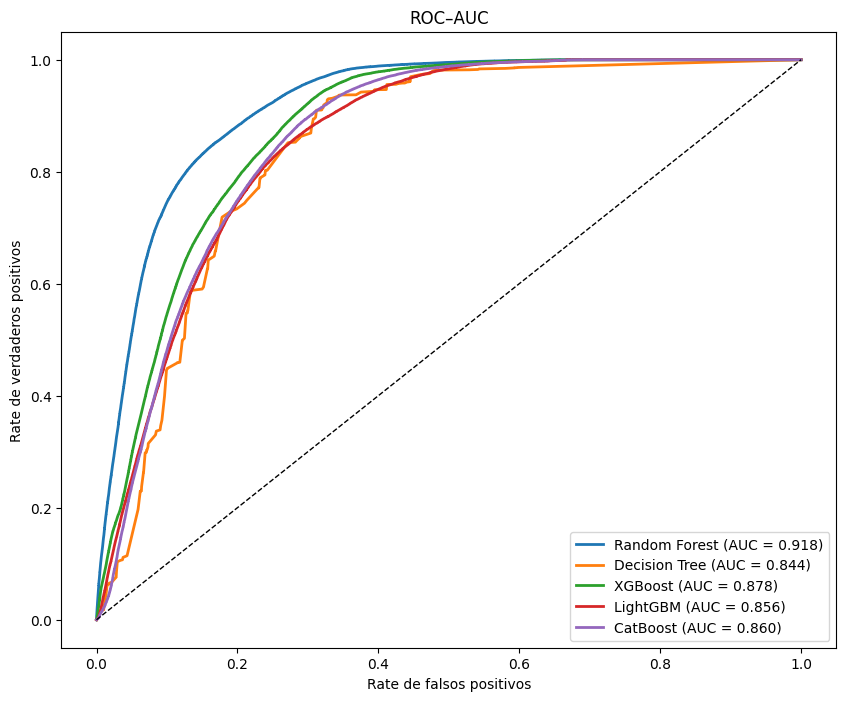

In [30]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)



plt.figure(figsize=(10, 8))

models = {
    'Random Forest': y_pred_proba_rf,
    'Decision Tree': y_pred_proba_dt,
    'XGBoost': y_pred_proba_xgb,
    'LightGBM': y_pred_proba_lgbm,
    'CatBoost': y_proba_cb
}

for model_name, y_score in models.items():
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Rate de falsos positivos')
plt.ylabel('Rate de verdaderos positivos')
plt.title('ROC–AUC')
plt.legend(loc='lower right')
plt.show()

Usando las curvas anteriores, notamos que `RandomForest`, `XGBoost`, `LightGBM` y `CatBoost` son bastante estables; esto no es de extrañarse ya que durante los entrenamientos de nuestros modelos fue posible apreciar que los que estuvieron basados en árboles tendieron a tener un mejor desempeño.

En este diagrama no tomamos en cuenta a `MLP` y tampoco a `BalancedForestClassifier` ya que no tuvieron buenos resultados para detectar la `Clase Objetivo (3)`.

# Selección de modelos y Fine-Tuning

Revisando los desempeños de los modelos anteriores, notamos lo siguiente:

- `RandomForestClassifier` ignora por completo la Clase `2`, pero es quien mejor predice la Clase `1` y uno de los mejores modelos para encontrar verdaderos positivos de la Clase `3`. Por medio de las curvas AUC-ROC notamos que el modelo es bastante estable, pero esto podría deberse al desbalance en nuestra distribución de clasificaciones ya que fue el que mejor desempeño tuvo respecto a detectarla. La `precision` de RandomForest sobre la clase objetivo es de las mejores respecto a los otros modelos.

- XGBoost tuvo un resultado bastante parecido a `RandomForestClassifier`, con la diferencia de que detecta de mejor manera la clase `2` respecto a verdaderos positivos. De igual manera, tiene un `recall` bastante bueno para la clase `3` pero su efectividad para predecirla correctamente es menor que `RandomForestClassifier`, aunque detectó más verdaderos positivos. Este modelo en general es un candidato para tener un desempeño de predicción más balanceado.

- `DecisionTree`, aunque es el modelo más rápido, no se encuentra especializado en detectar alguna clase. En este caso, incluso la Clase `1` tuvo problemas para ser detectada.

- `MLP` no generalizó bien la mayoría de clases, pero obtuvo un mejor rendimiento respecto a predecir los verderos positivos de  la Clase `2` que otros modelos. Ahora, revisando los resultados para la clase `3`, notamos que aunque tiene un recall parecido a `RandomForestClassifier`, su precisión fue bastante baja y por lo tanto daría muchos más falsos positivos que otros modelos.

- `BalancedRandomForestClassifier` no fue capaz de sobrellevar el desbalance en nuestro dataset, y esto causó un colapso total en identificar a la clase 0 y 2 de nuestro dataset. En esencia, el resultado de `BalancedRandomForest` es parecido a hacer una clasificación binaria, y aún así tuvo problemas para encontrar verdaderos positivos. Con esto, la `precision` de este modelo fue la mejor.

- `LightGBM` demostró ser uno de los modelos que generalizan mejor la distribución de las clasificaciones, y es uno de los mejores en predecir los verdaderos positivos de clase `3`, la cual es nuestra clase de interés. Con esto, su `precision` es de las más altas, y tiene un `F1_score` bastante más alto que otros modelos para la clase `3`. Respecto a la clase `2` y `0`, notamos que capturó casi el 30% de verdaderos positivos, lo que lo hace un modelo balanceado.

- `CatBoost` tuvo un rendimiento bastante similar a `LightGBM`, con la excepción de que la `precision` para la clase objetivo es menor que con `LightGBM`. Sin embargo, notamos con las curvas ROC-AUC que es un modelo bastante estable.

Por los motivos anteriores, consideramos que los mejores modelos a dar seguimiento para el fine-tuning del mismo es `LightGBM` y `CatBoost`, y por lo tanto, procederemos a optimizar el mismo. En general, notamos lo siguiente:

- `LightGBM` brilla por su capacidad de detectar casi todos los verdaderos positivos de la clase objetivo.
- `CatBoost`, aunque tiene una precisión un poco menor en comparación con `LightGBM`, notamos que generaliza de manera similar a todas las clases.
- Todos los modelos tuvieron problemas para detectar correctamente la clase `2`, y por lo tanto sospechamos que los patrones inherentes de esta clase son bastante complejos. Esto podría deberse a que los focos de infestación catalogados de esta manera son un estado transitorio y no un estado estable.
- Algo curioso es que las dos mejores implementaciones son frameworks como tal.

## Usamos Optuna para LightGBM

Al utilizar Bayesian Optimization para encontrar los mejores parámetros para LightGBM, nos encontramos con el reto de que la combinación de ciertas variaciones de parámetros causaba que BO no pudiera terminar. Esto se debe a que LightGBM  no convergía a una solución aceptable y empezaba a generar splits con nodos vacíos. Por lo tanto, tuvimos que adaptarnos a la situación.

Con esto, decidimos utilizar Otptuna para maximizar nuestro f1_score (que en teoría balancea lo que es `precision` y `recall`), de forma que encontremos de forma más parametrizable los mejores hiperparámetros de LightGBM.

A este momento en el Notebook, tenemos los siguientes resultados para la clase objetivo:

- `Precision`: 0.396
- `Recall`:  0.991
- `F1_Score`: 0.566

Con lo anterior, al tener un Recall bastante bueno, consideramos que podemos buscar optimizar la métrica de `F1 global`. Esto podría significar la reducción del recall, pero creemos que es un trade-off justo para asegurar que nuestro porcentaje de predicción de la clase objetivo sea mejor. Esto ayudará a reducir las "falsas" alertas que el modelo pueda generar.

In [36]:
lgbm_df = df_filtered.copy()

for col in ['state', 'municipality']:
    le = LabelEncoder()
    lgbm_df[col] = le.fit_transform(lgbm_df[col])

train_mask = lgbm_df['sampling_date'].dt.year < 2025
test_mask  = lgbm_df['sampling_date'].dt.year == 2025

exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date',
]

features = [col for col in lgbm_df.columns if col not in exclude_cols]

X_train, y_train = lgbm_df.loc[train_mask, features], lgbm_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = lgbm_df.loc[test_mask,  features], lgbm_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025


def objective_lgbm(trial):
    params = {
        "boosting_type": "gbdt",
        "objective": "multiclass",
        "num_class": 4,
        "class_weight": "balanced",
        "is_unbalance": False,
        "device_type": "gpu",
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 31, 120),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 200),
        "min_gain_to_split": 0.001,  
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "random_state": 42,
        "verbose": -1
    }

    model = LGBMClassifier(**params)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train, y_train, cv=tscv,
                             scoring="f1_macro", n_jobs=-1)
    return np.mean(scores)

lgbm_study = optuna.create_study(direction="maximize")
lgbm_study.optimize(objective_lgbm, n_trials=30)

print("\n\nMejores parametros:", lgbm_study.best_params)
print("Mejor F1_Macro:", lgbm_study.best_value)

[I 2025-10-19 11:29:54,077] A new study created in memory with name: no-name-aeb262f4-b43a-497e-b970-abfc9629a179
[I 2025-10-19 11:32:44,496] Trial 0 finished with value: 0.49325788026112116 and parameters: {'learning_rate': 0.08378059590225316, 'num_leaves': 88, 'max_depth': 14, 'feature_fraction': 0.9585765763973964, 'bagging_fraction': 0.7097706093371674, 'lambda_l1': 0.22922538600749498, 'lambda_l2': 3.6480267167730585, 'min_child_samples': 114, 'n_estimators': 533}. Best is trial 0 with value: 0.49325788026112116.
[I 2025-10-19 11:33:28,472] Trial 1 finished with value: 0.4803633085783711 and parameters: {'learning_rate': 0.0848806331458013, 'num_leaves': 100, 'max_depth': 5, 'feature_fraction': 0.890150100116327, 'bagging_fraction': 0.9214046836692897, 'lambda_l1': 0.19523488491263952, 'lambda_l2': 0.5038261763670865, 'min_child_samples': 22, 'n_estimators': 379}. Best is trial 0 with value: 0.49325788026112116.
[I 2025-10-19 11:35:05,703] Trial 2 finished with value: 0.503624368



Mejores parametros: {'learning_rate': 0.031205207400998834, 'num_leaves': 110, 'max_depth': 11, 'feature_fraction': 0.91959030797181, 'bagging_fraction': 0.7694621015318531, 'lambda_l1': 1.8616621273598788, 'lambda_l2': 2.6453430076619573, 'min_child_samples': 70, 'n_estimators': 299}
Mejor F1_Macro: 0.5104401429687768


In [37]:
lgbm_best_params = lgbm_study.best_params
lgbm_best_params

{'learning_rate': 0.031205207400998834,
 'num_leaves': 110,
 'max_depth': 11,
 'feature_fraction': 0.91959030797181,
 'bagging_fraction': 0.7694621015318531,
 'lambda_l1': 1.8616621273598788,
 'lambda_l2': 2.6453430076619573,
 'min_child_samples': 70,
 'n_estimators': 299}

### Probamos los mejores parámetros según Optuna para `LightGBM`

In [47]:
lgbm_df = df_filtered.copy()

for col in ['state', 'municipality']:
    le = LabelEncoder()
    lgbm_df[col] = le.fit_transform(lgbm_df[col])
    
    
categorical_features = ['municipality', 'state', 'critical_season' ]

train_mask = lgbm_df['sampling_date'].dt.year < 2025
test_mask  = lgbm_df['sampling_date'].dt.year == 2025

exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date'
]

features = [col for col in lgbm_df.columns if col not in exclude_cols]

X_train, y_train = lgbm_df.loc[train_mask, features], lgbm_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = lgbm_df.loc[test_mask,  features], lgbm_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025

lgbm_best_params = LGBMClassifier(
    boosting_type = "gbdt",
    objective = "multiclass",
    num_class = 4,
    class_weight = "balanced",
    is_unbalance = False,
    device_type = "gpu",
    min_gain_to_split = 0.001,  
    random_state = 42,
    verbose = -1,
    learning_rate= 0.031205207400998834,
    num_leaves= 110,
    max_depth= 11,
    feature_fraction= 0.91959030797181,
    bagging_fraction= 0.7694621015318531,
    lambda_l1= 1.8616621273598788,
    lambda_l2= 2.6453430076619573,
    min_child_samples= 70,
    n_estimators= 299
    
)

lgbm_best_params.fit(X_train, y_train)

y_pred_lgbm_best = lgbm_best_params.predict(X_test, categorical_features=categorical_features)


print("Resultados para LightGBM después de usar Optuna:\n\n")
print(classification_report(y_test, y_pred_lgbm_best, digits=3))

y_pred_proba_lgbm_best_params = lgbm_best_params.predict_proba(X_test)

Resultados para LightGBM después de usar Optuna:


              precision    recall  f1-score   support

           0      0.260     0.296     0.277     24445
           1      0.767     0.728     0.747     82928
           2      0.132     0.163     0.146      2544
           3      0.381     1.000     0.551       110

    accuracy                          0.619    110027
   macro avg      0.385     0.547     0.430    110027
weighted avg      0.639     0.619     0.628    110027



## Usamos Optuna junto a CatBoost

In [40]:
import optuna
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from catboost import CatBoostClassifier


# Copiamos el dataframe con la información
cb_df = df_filtered.copy()

# Hacemos un encoding basico para State y Municipalidad
for col in ['state', 'municipality']:
    le = LabelEncoder()
    cb_df[col] = le.fit_transform(cb_df[col])

# Generamos la mascara para obtener los datos de antes del 2025 y del 2025 por separada
train_mask = cb_df['sampling_date'].dt.year < 2025
test_mask  = cb_df['sampling_date'].dt.year == 2025

# Excluimos la variable objetivo (severity_encoded) y algunos unas variables o features que ya tenemos contenidos en nuestros
# features creados. `capture_count` no podemos tomarlo en cuenta porque se relaciona directamente con la severidad.
exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date'
]

# Cargamos los features a tomar en cuenta (obviamos los features en exclude_cols)
features = [col for col in cb_df.columns if col not in exclude_cols]

# Generamos nuestro split de entrenamiento y test por medio de las mascaras train_mask y test_mask
X_train, y_train = cb_df.loc[train_mask, features], cb_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = cb_df.loc[test_mask,  features], cb_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025


def objective_cb(trial):
    
    categorical_cols = ['state', 'municipality']
    
    params = {
        "iterations": trial.suggest_int("iterations", 300, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 64, 255),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise"]),
        "loss_function": "MultiClass",
        "eval_metric": "TotalF1",
        "auto_class_weights": "Balanced",
        "task_type": "GPU",
        "devices": "0",
        "random_seed": 42,
        "verbose": False,
        "allow_writing_files": False,
        "cat_features" : categorical_cols
    }
    
    model_cb = CatBoostClassifier(**params)

    tscv = TimeSeriesSplit(n_splits=3)
    
    scores = cross_val_score(
        model_cb, 
        X_train, 
        y_train,
        cv=tscv,
        scoring="f1_macro",
        n_jobs=1,
        error_score='raise'
    )

    return np.mean(scores)

cb_study = optuna.create_study(direction="maximize")
cb_study.optimize(objective_cb, n_trials=30, show_progress_bar=False)

print("\n\nMejores parámetros:", cb_study.best_params)
print("Mejor F1-macro:", cb_study.best_value)

[I 2025-10-19 12:42:00,613] A new study created in memory with name: no-name-18175c0e-f313-4fb1-a127-3411b0030e23
[I 2025-10-19 12:42:22,554] Trial 0 finished with value: 0.4835366004457098 and parameters: {'iterations': 410, 'learning_rate': 0.014229136329429605, 'depth': 4, 'l2_leaf_reg': 0.16301999144004828, 'bagging_temperature': 0.8311746834719845, 'border_count': 216, 'random_strength': 0.6233930850379468, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.4835366004457098.
[I 2025-10-19 12:42:58,197] Trial 1 finished with value: 0.4643555374262857 and parameters: {'iterations': 329, 'learning_rate': 0.012747468679225021, 'depth': 8, 'l2_leaf_reg': 0.15510008873590594, 'bagging_temperature': 0.7301501901318413, 'border_count': 214, 'random_strength': 1.7309716862973354, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.4835366004457098.
[I 2025-10-19 12:46:05,943] Trial 2 finished with value: 0.41808212040666143 and parameters: {'iterations': 1160, 'learning_rate



Mejores parámetros: {'iterations': 893, 'learning_rate': 0.03169683936081736, 'depth': 8, 'l2_leaf_reg': 1.0126729009882989, 'bagging_temperature': 0.13742770730370382, 'border_count': 238, 'random_strength': 1.490982729702571, 'grow_policy': 'SymmetricTree'}
Mejor F1-macro: 0.4992723431575114


In [41]:
cb_best_params = cb_study.best_params
cb_best_params

{'iterations': 893,
 'learning_rate': 0.03169683936081736,
 'depth': 8,
 'l2_leaf_reg': 1.0126729009882989,
 'bagging_temperature': 0.13742770730370382,
 'border_count': 238,
 'random_strength': 1.490982729702571,
 'grow_policy': 'SymmetricTree'}

### Probamos los mejores parámetros según Optuna para `CatBoost`

In [43]:
from catboost import CatBoostClassifier, Pool

# Copiamos el dataframe con la información
cb_df = df_filtered.copy()

# Hacemos un encoding basico para State y Municipalidad
for col in ['state', 'municipality']:
    le = LabelEncoder()
    cb_df[col] = le.fit_transform(cb_df[col])

# Generamos la mascara para obtener los datos de antes del 2025 y del 2025 por separada
train_mask = cb_df['sampling_date'].dt.year < 2025
test_mask  = cb_df['sampling_date'].dt.year == 2025

# Excluimos la variable objetivo (severity_encoded) y algunos unas variables o features que ya tenemos contenidos en nuestros
# features creados. `capture_count` no podemos tomarlo en cuenta porque se relaciona directamente con la severidad.
exclude_cols = [
    'severity_encoded','tramp_id', 'capture_count', 
    'month', 'year-month', 'sampling_date',
]

# Cargamos los features a tomar en cuenta (obviamos los features en exclude_cols)
features = [col for col in cb_df.columns if col not in exclude_cols]

# Generamos nuestro split de entrenamiento y test por medio de las mascaras train_mask y test_mask
X_train, y_train = cb_df.loc[train_mask, features], cb_df.loc[train_mask, 'severity_encoded'] # El train dataset es la data historica de 2014 a 2024
X_test,  y_test  = cb_df.loc[test_mask,  features], cb_df.loc[test_mask,  'severity_encoded'] # El test dataset es la data a partir de 2025


cat_model_best = CatBoostClassifier(                 
    loss_function='MultiClass',    
    eval_metric='TotalF1',         
    auto_class_weights='Balanced', 
    random_seed=42,
    task_type='GPU',               
    verbose=100,
    iterations= 893,
    learning_rate= 0.03169683936081736,
    depth= 8,
    l2_leaf_reg= 1.0126729009882989,
    bagging_temperature= 0.13742770730370382,
    border_count= 238,
    random_strength= 1.490982729702571,
    grow_policy= 'SymmetricTree'
)

categorical_cols = ['state', 'municipality']

cat_model_best.fit(
    X_train,
    y_train,
    cat_features=categorical_cols if 'categorical_cols' in locals() else None,
    eval_set=(X_test, y_test),
    use_best_model=True
)

y_pred_cd_best = cat_model_best.predict(X_test)
y_pred_cd_best = y_pred.flatten()

print("\n\nResultados para CatBoost según Optuna:\n")
print(classification_report(y_test, y_pred))

0:	learn: 0.6823539	test: 0.5856466	best: 0.5856466 (0)	total: 39ms	remaining: 34.8s
100:	learn: 0.7215748	test: 0.5694917	best: 0.5856466 (0)	total: 4.87s	remaining: 38.1s
200:	learn: 0.7439478	test: 0.5617129	best: 0.5856466 (0)	total: 10.2s	remaining: 35.1s
300:	learn: 0.7567374	test: 0.5326864	best: 0.5856466 (0)	total: 15.5s	remaining: 30.4s
400:	learn: 0.7668665	test: 0.5188755	best: 0.5856466 (0)	total: 21.5s	remaining: 26.3s
500:	learn: 0.7737156	test: 0.5025127	best: 0.5856466 (0)	total: 27.4s	remaining: 21.4s
600:	learn: 0.7801252	test: 0.4960820	best: 0.5856466 (0)	total: 32.7s	remaining: 15.9s
700:	learn: 0.7854649	test: 0.4864109	best: 0.5856466 (0)	total: 38.1s	remaining: 10.4s
800:	learn: 0.7902415	test: 0.4780377	best: 0.5856466 (0)	total: 43.4s	remaining: 4.99s
892:	learn: 0.7939429	test: 0.4733942	best: 0.5856466 (0)	total: 49s	remaining: 0us
bestTest = 0.5856466408
bestIteration = 0
Shrink model to first 1 iterations.


Resultados para CatBoost según Optuna:

       

## Comparación de modelos luego de fine-tuning

# Conclusiones

https://arxiv.org/abs/2201.08528

https://arxiv.org/abs/2404.19494

https://www.sciencedirect.com/science/article/pii/S1532046424000844?via%3Dihub
